In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu May  9 16:30:35 2019

@author: Chan Chak Tong
"""

import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import os

import numpy as np
from PIL import Image
from glob import glob

<h2>Q1-1 Preprocessing</h2>

In [2]:
#%%
class DataLoader:
    def __init__(self, path, img_size = (128, 128, 3)):
        self.TRAIN_DATA_PATH = path + '/train/'
        self.TEST_DATA_PATH = path + '/val/'
        
        self.img_size = img_size
        self.class_num = len(glob(self.TRAIN_DATA_PATH + '*'))
        self.train_sample_num = 1000
        self.test_sample_num = 400
    
        self.classes_name = os.listdir(self.TRAIN_DATA_PATH)
        print('Classes', self.classes_name)
        
    def __imread(self, path):
        return Image.open(path).convert('RGB').resize(self.img_size[:-1])
    
    def train_data_generator(self, batch_size = 10, channel_first=True):
        path_list = glob(self.TRAIN_DATA_PATH + '*/*')
        y = np.repeat(np.arange(self.class_num), self.train_sample_num)
        
        # Shuffle data
        idx = np.arange(len(path_list))
        np.random.shuffle(idx)
        path_list, y = list(np.array(path_list)[idx]), y[idx]
        
        for i in range(len(path_list) // batch_size):
            batch_slice = slice(i*batch_size, (i+1)*batch_size)
            x = np.zeros((batch_size, ) + self.img_size)
            for img_idx, img_path in enumerate(path_list[batch_slice]):
                x[img_idx] = self.__imread(img_path)
            x = np.swapaxes(x, 1, -1) if channel_first else x
            yield x / 255, y[batch_slice]
        
    def test_data_generator(self, batch_size = 10, channel_first=True):
        path_list = glob(self.TEST_DATA_PATH + '*/*')
        y = np.repeat(np.arange(self.class_num), self.test_sample_num)

        for i in range(len(path_list) // batch_size):
            batch_slice = slice(i*batch_size, (i+1)*batch_size)
            x = np.zeros((batch_size, ) + self.img_size)
            for img_idx, img_path in enumerate(path_list[batch_slice]):
                x[img_idx] = self.__imread(img_path)
            x = np.swapaxes(x, 1, -1) if channel_first else x
            yield x / 255, y[batch_slice]
        

<h2>Q1-2 CNN construction</h2>
<p>目前是架構二</p>

In [3]:
class CNN(nn.Module):
    def __init__(self, class_num=10, img_size=(128, 128, 3)):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
                nn.Conv2d(img_size[-1], 64, kernel_size=4, padding=1, stride=2),
                nn.ReLU(),
                nn.Dropout(0.25))
        self.conv2 = nn.Sequential(
                nn.Conv2d(64, 32, kernel_size=4, padding=1, stride=2),
                nn.ReLU(),
                nn.Dropout(0.25))
        self.conv3 = nn.Sequential(
                nn.Conv2d(32, 16, kernel_size=4, padding=1, stride=2),
                nn.ReLU(),
                nn.Dropout(0.25))
        self.conv4 = nn.Sequential(
                nn.Conv2d(16, 8, kernel_size=4, padding=1, stride=2),
                nn.ReLU(),
                nn.Dropout(0.25))
        self.output = nn.Linear(512, class_num)
        
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters())
        
    def forward(self, x):
        h = self.conv1(x)
        h = self.conv2(h)
        h = self.conv3(h)
        h = self.conv4(h)
        h = h.view(h.size(0), -1)
        return self.output(h)
    
    def accuracy(self, y_true, y_pred):
        y_true = y_true if isinstance(y_true, np.ndarray) else y_true.cpu().numpy()
        y_pred = y_pred if isinstance(y_pred, np.ndarray) else y_pred.cpu().detach().numpy()
        identity = np.sum(y_true == np.argmax(y_pred, axis=1))
        return identity / len(y_true)
    
    def fit(self, epochs=200, batch_size=24):
        history = np.zeros((epochs, 4))
        global dataloader
        for e in range(epochs):
            print('[Epoch %d]' % e, end='')
            self.train()
            mini_train_loss, mini_train_acc = [], []
            for train_x, train_y in dataloader.train_data_generator(batch_size=batch_size):
                x = torch.from_numpy(train_x).type('torch.FloatTensor').cuda()
                y = torch.from_numpy(train_y).type('torch.LongTensor').cuda()

                train_prediction = self(x)
                loss = self.loss_func(train_prediction, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                mini_train_loss.append(loss.data.tolist())
                mini_train_acc.append(self.accuracy(y, train_prediction))

            train_loss = np.mean(mini_train_loss)
            train_acc = np.mean(mini_train_acc)
            
            self.eval()
            mini_test_loss, mini_test_acc = [], []
            for test_x, test_y in dataloader.test_data_generator(batch_size=16):
                x = torch.from_numpy(test_x).type('torch.FloatTensor').cuda()
                y = torch.from_numpy(test_y).type('torch.LongTensor').cuda()

                test_prediction = self(x)
                mini_test_loss.append(self.loss_func(test_prediction, y).data.tolist())
                mini_test_acc.append(self.accuracy(y, test_prediction))
                
            test_loss = np.mean(mini_test_loss)
            test_acc = np.mean(mini_test_acc)
            
            print('[Train - Loss: %f, Acc: %f] [Test - Loss: %f, Acc: %f]' % (train_loss, train_acc, test_loss, test_acc))
            history[e] = np.array([train_loss, train_acc, test_loss, test_acc])
        torch.save(self, './classifier_2.pkl')
        return history

    def predict(self, x, batch_size=128):
        x = np.swapaxes(x, -1, 1) if x.shape[1] != 3 else x
        y = np.zeros((len(x), 10))
        for batch_idx in range(len(x) // batch_size):
            batch_slice = slice(batch_idx*batch_size, (batch_idx+1)*batch_size)
            batch_x = torch.from_numpy(x[batch_slice]).type('torch.FloatTensor').cuda()
            y[batch_slice] = self(batch_x).cpu().detach().numpy()
        return y

<h4>不訓練的話不要執行這一格和下一格</h4>

In [ ]:
classifier = CNN().cuda()
dataloader = DataLoader('./animal-10/')

epochs = 150
batch_size = 200

history = classifier.fit(epochs=epochs, batch_size=batch_size)

<h4>Plot learning Curve and accuracy curve</h4>

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.T[0], label='train')
plt.plot(history.T[2], label='test')
plt.title('CNN Learning Curve')
plt.legend()
plt.show()

plt.plot(history.T[1], label='train')
plt.plot(history.T[3], label='test')
plt.title('CNN Accuracy Curve')
plt.legend()
plt.show()

<h2>Q1-3 Evaluation</h2>
<h4>可以不訓練，選擇載入已訓練好的CNN</h4>
<h5>classifier_1.pkl = 第一個架構</h5>
<h5>classifier_2.pkl = 第二個架構</h5>

In [4]:
classifier = CNN()
classifier = torch.load('./classifier_2.pkl')
classifier.eval()
dataloader = DataLoader('./animal-10/')
test_generator = dataloader.test_data_generator(batch_size=2, channel_first=False)

Classes ['dog', 'chicken', 'cat', 'cow', 'butterfly', 'horse', 'sheep', 'elephant', 'spider', 'squirrel']


可以一直按這一格去生產圖片

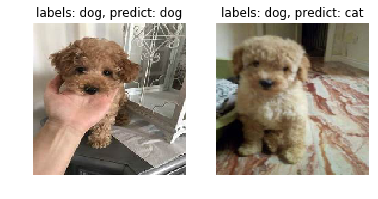

In [5]:
x, y = next(test_generator)
pred_0, pred_1 = classifier.predict(x, batch_size=2)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(x[0])
axs[1].imshow(x[1])
axs[0].axis('off')
axs[1].axis('off')
axs[0].title.set_text('labels: %s, predict: %s' % (dataloader.classes_name[y[0]], dataloader.classes_name[pred_0.argmax()]))
axs[1].title.set_text('labels: %s, predict: %s' % (dataloader.classes_name[y[1]], dataloader.classes_name[pred_1.argmax()]))
plt.show()

<h3>Accuracy of each classes</h3>

In [7]:
test_generator = dataloader.test_data_generator(batch_size=400, channel_first=False)
acc = []
while True:
    x, y = next(test_generator, [None, None])
    if x is None:
        break
    prediction = classifier.predict(x, batch_size=400)
    accuracy = classifier.accuracy(y, prediction)
    acc.append(accuracy)

In [8]:
print('Accuracy of classes')
for c, a in zip(dataloader.classes_name, acc):
    print('%s : %d%%' % (c, a*100))

Accuracy of classes
dog : 41%
chicken : 67%
cat : 70%
cow : 51%
butterfly : 67%
horse : 54%
sheep : 56%
elephant : 65%
spider : 73%
squirrel : 58%
